# PGA: Capstone Project - The Battle of Neighborhoods (Week 1)
## Data retrieval and exploration

**Importing the libraries for our tasks.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim

import folium

import json
import requests
from pandas.io.json import json_normalize

### First data source: Scraping German cities wikipedia table

In [2]:
url='https://de.wikipedia.org/wiki/Liste_der_Gro%C3%9Fst%C3%A4dte_in_Deutschland'

dfs = pd.read_html(url, attrs={'class': 'wikitable sortable zebra mw-datatable'}, thousands=".")

gercities = dfs[0].droplevel(level=0, axis=1)
gercities.drop([81, 82], inplace=True)

gercities = gercities[['Name', '2018', 'Fläche in km² (2016)']]
gercities.rename(columns={"Name": "City", "2018": "Population", "Fläche in km² (2016)": "Area"}, inplace=True)

print(gercities.shape)
print(gercities.dtypes)
gercities.head()

(81, 3)
City          object
Population    object
Area          object
dtype: object


,City,Population,Area
0,Berlin1,3644826,"891,68"
1,Hamburg1,1841179,"755,22"
2,München,1471508,"310,70"
3,Köln1,1085664,"405,02"
4,Frankfurt am Main,753056,"248,31"


**Conversion of datatypes, replacement of umlauts, deletion of remark numbers.**

In [3]:
gercities = gercities.convert_dtypes()

gercities['Population'] = gercities['Population'].astype('int')
gercities['Area'] = gercities['Area'].str.replace(',','.').astype('float')

gercities['City'] = gercities['City'].str.replace('ü', 'ue')
gercities['City'] = gercities['City'].str.replace('ä', 'ae')
gercities['City'] = gercities['City'].str.replace('ö', 'oe')
gercities['City'] = gercities['City'].str.replace('ß', 'ss')

gercities['City'] = gercities['City'].str.replace('[^a-zA-Z ]', '')

print(gercities.dtypes)
gercities.head()

City           string
Population      int64
Area          float64
dtype: object


,City,Population,Area
0,Berlin,3644826,891.68
1,Hamburg,1841179,755.22
2,Muenchen,1471508,310.70
3,Koeln,1085664,405.02
4,Frankfurt am Main,753056,248.31


**Histogram plot by population.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6c78429d0>]],
      dtype=object)

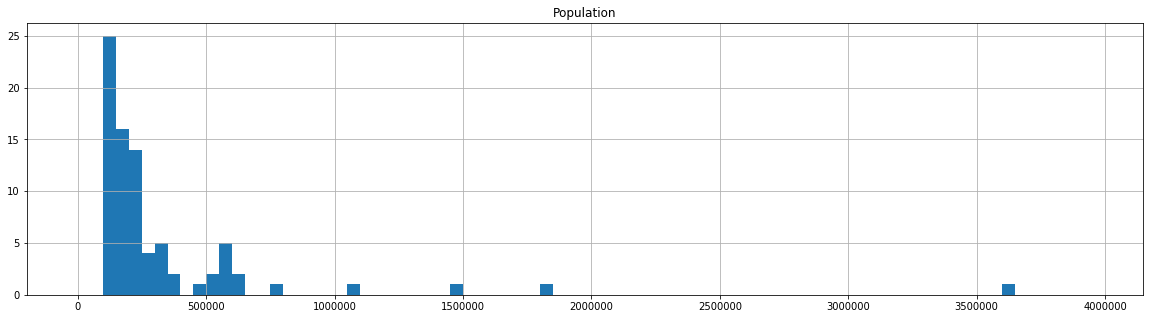

In [4]:
gercities.hist(column='Population', bins=np.arange(0,4000000,50000), figsize=(20, 5))

**Statistical summary**

In [5]:
gercities.describe().round(3)

,Population,Area
count,81.000,81.000
mean,328886.728,172.062
std,469869.304,128.462
min,100194.000,44.890
25%,126329.000,99.520
50%,188814.000,141.060
75%,313092.000,204.140
max,3644826.000,891.680


Half of the cities have a population of less than 188,814 and area of less than 141.06 sqkm.

**Adding geolocation**

In [6]:
lat_list=[]
lng_list=[]

for row in range(gercities.shape[0]):
    geolocator = Nominatim(user_agent="coursera_capstone")
    location = geolocator.geocode('{}, Germany'.format(gercities.iloc[row, 0]))
    try:
        lat_list.append(location.latitude)
        lng_list.append(location.longitude)
    except AttributeError:
        lat_list.append(np.nan)
        lng_list.append(np.nan)
        continue

gercities.insert(loc=3, column='Latitude', value=lat_list)
gercities.insert(loc=4, column='Longitude', value=lng_list)

print(gercities.shape)
print(gercities.dtypes)
gercities.head()

(81, 5)
City           string
Population      int64
Area          float64
Latitude      float64
Longitude     float64
dtype: object


,City,Population,Area,Latitude,Longitude
0,Berlin,3644826,891.68,52.517037,13.388860
1,Hamburg,1841179,755.22,53.543764,10.009913
2,Muenchen,1471508,310.70,48.137108,11.575382
3,Koeln,1085664,405.02,50.938361,6.959974
4,Frankfurt am Main,753056,248.31,50.110644,8.682092


In [7]:
# Show errors and drop the rows
print(gercities.loc[gercities['Latitude'].isna()])
gercities.drop(gercities[gercities['Latitude'].isna()].index, axis=0, inplace=True)

                   City  Population   Area  Latitude  Longitude
45  Muelheim an derRuhr      170880  91.28       NaN        NaN


**Mapping the locations of the cities**

In [8]:
# creating the map
map_ger_cities = folium.Map(location=[51.351, 10.454], zoom_start=5.5)

# add markers of citis to map
for lat, lng, city, pop in zip(gercities['Latitude'], gercities['Longitude'], gercities['City'], gercities['Population']):
    label = '{} (Population: {})'.format(city, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ger_cities)

map_ger_cities

### Second data source: Retrieving the venues for the cities from Foursquare.

In [9]:
CLIENT_ID = 'AOUOE4WYOQXAMZABF1J3HUQCXZ0GBEETIUCZDQOUYR0JGRQD' # your Foursquare ID
CLIENT_SECRET = 'MCY5M5APBTGR1J2QR20PQLZ2YVJBXRBG4OOML1ZHAMLHYCGR' # your Foursquare Secret
VERSION = '20200522' # Foursquare API version
LIMIT = 1000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AOUOE4WYOQXAMZABF1J3HUQCXZ0GBEETIUCZDQOUYR0JGRQD
CLIENT_SECRET:MCY5M5APBTGR1J2QR20PQLZ2YVJBXRBG4OOML1ZHAMLHYCGR


In [10]:
def getNearbyVenues(cities, latitudes, longitudes, radius):
    
    venues_list=[]
    for city, lat, lng in zip(cities, latitudes, longitudes):
        print(city)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city, 
            lat, 
            lng, 
            v['venue']['name'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

**Calculating the search radius using the median city size (area)**

In [11]:
radius = round(np.sqrt(gercities['Area'].median()/np.pi)*1000)
radius

6747.0

In [12]:
gercities_venues = getNearbyVenues(cities=gercities['City'],
                                   latitudes=gercities['Latitude'],
                                   longitudes=gercities['Longitude'],
                                   radius=radius
                                  )

Berlin
Hamburg
Muenchen
Koeln
Frankfurt am Main
Stuttgart
Duesseldorf
Leipzig
Dortmund
Essen
Bremen
Dresden
Hannover
Nuernberg
Duisburg
Bochum
Wuppertal
Bielefeld
Bonn
Muenster
Karlsruhe
Mannheim
Augsburg
Wiesbaden
Moenchengladbach 
Gelsenkirchen
Braunschweig
Kiel
Aachen
Chemnitz
Halle Saale
Magdeburg
Freiburg im Breisgau
Krefeld
Luebeck
Mainz
Erfurt
Oberhausen
Rostock
Kassel
Hagen
Saarbruecken
Hamm
Potsdam
Ludwigshafen am Rhein
Oldenburg Oldb
Osnabrueck
Leverkusen
Heidelberg
Solingen
Darmstadt
Herne
Neuss
Regensburg
Paderborn
Ingolstadt
Offenbach am Main
Wuerzburg
Fuerth
Ulm
Heilbronn
Pforzheim
Wolfsburg
Goettingen
Bottrop
Reutlingen
Koblenz
Bremerhaven 
Recklinghausen
Bergisch Gladbach
Erlangen
Jena
Remscheid
Trier
Salzgitter 
Moers
Siegen
Hildesheim
Cottbus
Guetersloh


In [13]:
print(gercities_venues.dtypes)
gercities_venues.head()

City               object
City Latitude     float64
City Longitude    float64
Venue              object
Venue Category     object
dtype: object


,City,City Latitude,City Longitude,Venue,Venue Category
0,Berlin,52.517037,13.38886,Dussmann das KulturKaufhaus,Bookstore
1,Berlin,52.517037,13.38886,Dussmann English Bookshop,Bookstore
2,Berlin,52.517037,13.38886,Konzerthaus Berlin,Concert Hall
3,Berlin,52.517037,13.38886,Gendarmenmarkt,Plaza
4,Berlin,52.517037,13.38886,Brandenburger Tor,Monument / Landmark


Creating the onehot encoded and grouped dataframe for later use.

In [14]:
gercities_venues_onehot = pd.get_dummies(gercities_venues[['Venue Category']], prefix="", prefix_sep="")
gercities_venues_onehot['City'] = gercities_venues['City'] 
fixed_columns = [gercities_venues_onehot.columns[-1]] + list(gercities_venues_onehot.columns[:-1])
gercities_venues_onehot = gercities_venues_onehot[fixed_columns]
gercities_venues_grouped = gercities_venues_onehot.groupby('City').mean().reset_index()
gercities_venues_grouped.head()

,City,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Apple Wine Pub,Aquarium,Arcade,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo,Zoo Exhibit
0,Aachen,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,...,0.000000,0.00,0.00,0.0,0.01,0.0,0.0,0.0,0.010000,0.000000
1,Augsburg,0.0,0.0,0.00,0.0,0.000000,0.01,0.0,0.0,0.0,...,0.000000,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.010000,0.000000
2,Bergisch Gladbach,0.0,0.0,0.00,0.0,0.025316,0.00,0.0,0.0,0.0,...,0.000000,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.012658
3,Berlin,0.0,0.0,0.01,0.0,0.000000,0.00,0.0,0.0,0.0,...,0.000000,0.01,0.02,0.0,0.04,0.0,0.0,0.0,0.000000,0.000000
4,Bielefeld,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,...,0.010638,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.010638,0.000000


**Grouping the original Foursquare dataframe by city to see how many venues were found per city.**

**Adding the city location, population, and a new metric: venue count per population.**

In [15]:
gercities_venues_count = gercities_venues.groupby(['City']).count()

gercities_venues_count.reset_index(inplace=True)

gercities_venues_count.drop(columns=['Venue Category', 'City Latitude', 'City Longitude'], inplace=True)

gercities_venues_count.rename(columns={'Venue': 'Venues'}, inplace=True)

gercities_venues_count = pd.merge(gercities_venues_count,
                                  gercities,
                                  on='City',
                                  how='left')

gercities_venues_count['Venues per Population'] = gercities_venues_count.apply(lambda row: row.Venues/row.Population, axis = 1)
gercities_venues_count = gercities_venues_count.round({'Venues per Population': 6})

gercities_venues_count['Venues per Area'] = gercities_venues_count.apply(lambda row: row.Venues/row.Area, axis = 1)
gercities_venues_count = gercities_venues_count.round({'Venues per Area': 6})


print(gercities_venues_count.dtypes)
gercities_venues_count.head()

City                      object
Venues                     int64
Population                 int64
Area                     float64
Latitude                 float64
Longitude                float64
Venues per Population    float64
Venues per Area          float64
dtype: object


,City,Venues,Population,Area,Latitude,Longitude,Venues per Population,Venues per Area
0,Aachen,100,247380,160.85,50.776351,6.083862,0.000404,0.621697
1,Augsburg,100,295135,146.84,48.366804,10.898697,0.000339,0.681013
2,Bergisch Gladbach,79,111966,83.09,50.992930,7.127738,0.000706,0.950776
3,Berlin,100,3644826,891.68,52.517037,13.388860,0.000027,0.112148
4,Bielefeld,94,333786,258.82,52.019101,8.531007,0.000282,0.363187


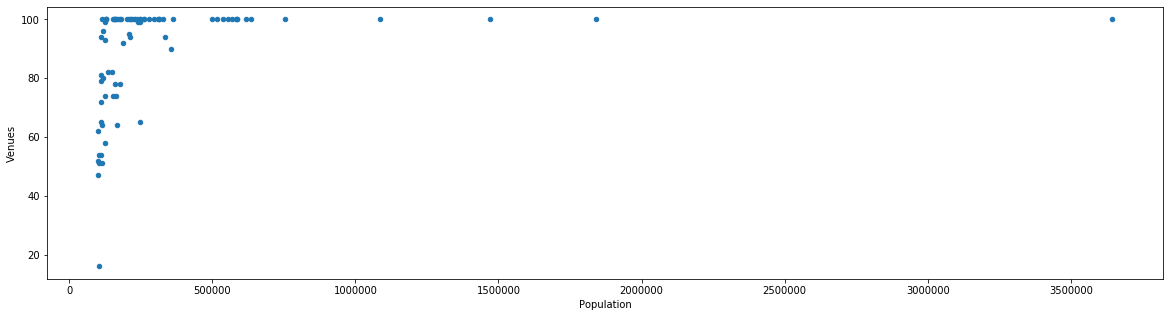

In [16]:
gercities_venues_count.plot.scatter(x='Population', y='Venues', figsize=(20,5))

Of course, bigger cities reach the maximum retrievable count of 100 venues easily.

But one can see, that there is quite a range in the venue count for the smaller cities.

To make this range more distinctable one can plot the population on a logarithmic axis.

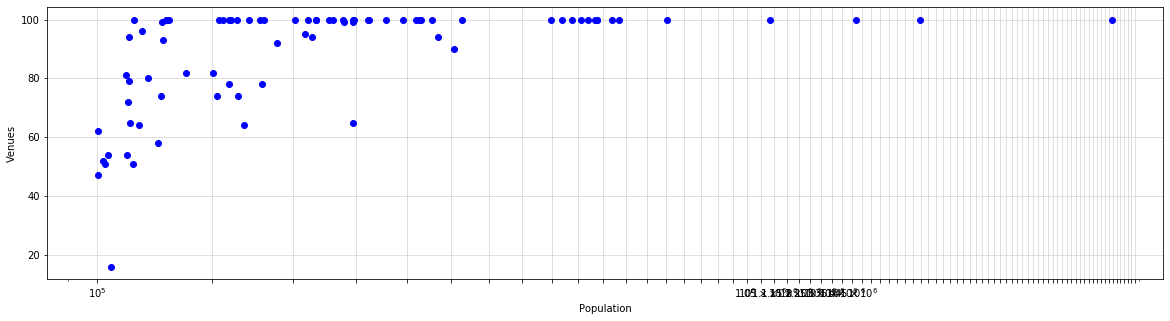

In [17]:
x_data = gercities_venues_count['Population']
y_data = gercities_venues_count['Venues']

fig = plt.figure(figsize=(20,5))
ax = plt.gca(xscale='log', xticks=np.arange(0,4000000,50000))
ax.plot(x_data, y_data, 'o', c='blue')
ax.set_xlabel('Population')
ax.set_ylabel('Venues')
ax.grid(alpha=0.5)

Now one can see that almost every city with a population bigger than 250k reaches the limit of 100 venue counts (except for tow cities).

**Due to complexity, I will only compare cities with less than 250k inhabitants.**
**Let's create a reduced dataframe.**

In [18]:
max_pop = 250000

gercities_venues_count_red = gercities_venues_count.loc[gercities_venues_count['Population']<max_pop]
gercities_venues_count_red.reset_index(drop=True, inplace=True)

print(gercities_venues_count_red.shape)
gercities_venues_count_red.head()

(54, 8)


,City,Venues,Population,Area,Latitude,Longitude,Venues per Population,Venues per Area
0,Aachen,100,247380,160.85,50.776351,6.083862,0.000404,0.621697
1,Bergisch Gladbach,79,111966,83.09,50.992930,7.127738,0.000706,0.950776
2,Bottrop,96,117383,100.61,51.521581,6.929204,0.000818,0.954180
3,Braunschweig,100,248292,192.18,52.264658,10.523607,0.000403,0.520346
4,Bremerhaven,51,113634,93.82,53.552226,8.586551,0.000449,0.543594


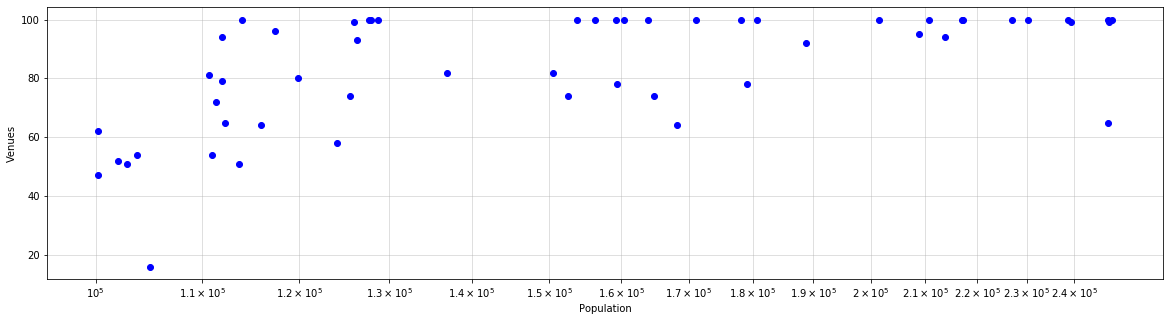

In [19]:
x_data = gercities_venues_count_red['Population']
y_data = gercities_venues_count_red['Venues']

fig = plt.figure(figsize=(20,5))
ax = plt.gca(xscale='log', xticks=np.arange(0,250000,10000))
ax.plot(x_data, y_data, 'o', c='blue')
ax.set_xlabel('Population')
ax.set_ylabel('Venues')
ax.grid(alpha=0.5)

Let's show them on the map.

In [20]:
# creating the map
map_gercities_venues_count = folium.Map(location=[51.351, 10.454], zoom_start=5.5)

# add markers of citis to map
for lat, lng, city, pop, vperpop in zip(gercities_venues_count_red['Latitude'], gercities_venues_count_red['Longitude'], gercities_venues_count_red['City'], gercities_venues_count_red['Population'], gercities_venues_count_red['Venues per Population']):
    label = '{} (Population: {}, Venues per Population: {})'.format(city, pop, vperpop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_gercities_venues_count)

map_gercities_venues_count

**Creating the dataframe for these selected cities that will be used for our machine learning algorithms.**

In [22]:
gercities_venues_count_red_grouped = pd.merge(gercities_venues_count_red,
                                              gercities_venues_grouped,
                                              on='City',
                                              how='inner')
print(gercities_venues_count_red_grouped.shape)
gercities_venues_count_red_grouped.head()

(54, 365)


,City,Venues,Population,Area,Latitude,Longitude,Venues per Population,Venues per Area,Advertising Agency,Afghan Restaurant,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo,Zoo Exhibit
0,Aachen,100,247380,160.85,50.776351,6.083862,0.000404,0.621697,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.01,0.0,0.0,0.0,0.010000,0.000000
1,Bergisch Gladbach,79,111966,83.09,50.992930,7.127738,0.000706,0.950776,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.012658
2,Bottrop,96,117383,100.61,51.521581,6.929204,0.000818,0.954180,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.010417,0.000000
3,Braunschweig,100,248292,192.18,52.264658,10.523607,0.000403,0.520346,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.010000,0.000000
4,Bremerhaven,51,113634,93.82,53.552226,8.586551,0.000449,0.543594,0.0,0.0,...,0.0,0.0,0.039216,0.0,0.00,0.0,0.0,0.0,0.019608,0.000000


**There are still 21 cities left, that reach the venue count limit of 100.**

**I will keep them for now.**

In [23]:
gercities_venues_count_red_grouped.loc[gercities_venues_count_red_grouped['Venues']==100]

,City,Venues,Population,Area,Latitude,Longitude,Venues per Population,Venues per Area,Advertising Agency,Afghan Restaurant,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo,Zoo Exhibit
0,Aachen,100,247380,160.85,50.776351,6.083862,0.000404,0.621697,0.0,0.0,...,0.00,0.0,0.00,0.0,0.01,0.00,0.0,0.0,0.01,0.00
3,Braunschweig,100,248292,192.18,52.264658,10.523607,0.000403,0.520346,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.01,0.00
7,Darmstadt,100,159207,122.09,49.872775,8.651177,0.000628,0.819068,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00
10,Freiburg im Breisgau,100,230241,153.06,47.996090,7.849400,0.000434,0.653339,0.0,0.0,...,0.00,0.0,0.00,0.0,0.01,0.00,0.0,0.0,0.01,0.00
11,Fuerth,100,127748,63.35,49.477263,10.989616,0.000783,1.578532,0.0,0.0,...,0.01,0.0,0.00,0.0,0.01,0.00,0.0,0.0,0.00,0.00
17,Heidelberg,100,160355,108.84,49.409358,8.694724,0.000624,0.918780,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.01,0.00
19,Herne,100,156374,51.42,51.538039,7.219985,0.000639,1.944769,0.0,0.0,...,0.02,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00
23,Kassel,100,201585,106.78,51.315455,9.492410,0.000496,0.936505,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00
25,Koblenz,100,114024,105.13,50.353328,7.594395,0.000877,0.951203,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00
26,Krefeld,100,227020,137.77,51.333120,6.562334,0.000440,0.725847,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.01,0.02


## The dataframe is now ready for our data science methods.